<a href="https://www.kaggle.com/code/bernardrr/houses-in-lekki?scriptVersionId=104097948" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Predicting House Prices in Lekki**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nigeria-houses-and-prices-dataset/info.txt
/kaggle/input/nigeria-houses-and-prices-dataset/nigeria_houses_data.csv


In [2]:
df = pd.read_csv("../input/nigeria-houses-and-prices-dataset/nigeria_houses_data.csv")
df.sort_values(by="price").tail(10)

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
20602,4.0,5.0,5.0,4.0,Block of Flats,Ikoyi,Lagos,1.500000e+10
13490,3.0,3.0,3.0,4.0,Semi Detached Duplex,Ajah,Lagos,4.200000e+10
17383,4.0,4.0,5.0,3.0,Detached Duplex,Ajah,Lagos,5.000000e+10
15806,5.0,5.0,5.0,1.0,Detached Duplex,Ifako-Ijaiye,Lagos,5.500000e+10
15836,5.0,6.0,7.0,4.0,Terraced Duplexes,Guzape District,Abuja,8.500000e+10
7098,5.0,5.0,6.0,4.0,Semi Detached Duplex,Lekki,Lagos,1.250000e+11
4327,5.0,5.0,6.0,4.0,Detached Duplex,Lekki,Lagos,1.600000e+11
15962,9.0,9.0,1.0,4.0,Detached Duplex,Lekki,Lagos,3.500000e+11
6632,4.0,4.0,5.0,4.0,Semi Detached Duplex,Ikoyi,Lagos,4.500000e+11
4096,7.0,7.0,8.0,8.0,Detached Duplex,Ikoyi,Lagos,1.800000e+12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


# **Exploratory Data Analysis**


In [4]:
# Unique number of states
state_no = df["state"].nunique()
print(f"There are {state_no} unique states in the dataset")

# Unique number of towns
towns_no = df["town"].nunique()
print(f"There are {towns_no} unique towns in the dataset")

There are 25 unique states in the dataset
There are 189 unique towns in the dataset


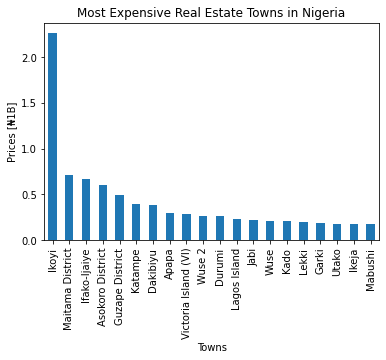

In [5]:
(
    (df.groupby("town")['price']
    .mean()/1e9)
    .sort_values(ascending=False)
    .head(20)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1B]",
         title = "Most Expensive Real Estate Towns in Nigeria")
);

During analysis, it could intuitively be noticed that houses in *Ifako-Ijaiye* cannot be in the league of houses in *Maitama District*. There had to be outliers contributing to this. It was discovered that a house in "Ifako-Ijaiye" was selling for about 55 billion naira, quite absurd.

Also, houses in *Ikoyi* are quite expensive but still, the gap was unexpected. Further investigation showed that a house was selling for about *1.8 trillion naira*. Whether the house is worth it or not is not the question; the effect was harmful to this dataset.

In [6]:
# Detecting suspected outlier
print(df[df["town"]=="Ikoyi"].max())
print(df[df["town"]=="Ifako-Ijaiye"].max())

bedrooms                       9.0
bathrooms                      9.0
toilets                        9.0
parking_space                  9.0
title            Terraced Duplexes
town                         Ikoyi
state                        Lagos
price              1800000000000.0
dtype: object
bedrooms                       7.0
bathrooms                      8.0
toilets                        8.0
parking_space                  8.0
title            Terraced Bungalow
town                  Ifako-Ijaiye
state                        Lagos
price                55000000000.0
dtype: object


### Removing Outliers

In [7]:
trim_df = q1, q9 = df["price"].quantile([0.15,0.85])
mask_df = df["price"].between(q1,q9)
trimmed_df = df[mask_df]
trimmed_df

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
6,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0
8,1.0,1.0,1.0,1.0,Detached Duplex,Lekki,Lagos,200000000.0
...,...,...,...,...,...,...,...,...
24318,4.0,5.0,5.0,4.0,Semi Detached Duplex,Lekki,Lagos,110000000.0
24320,3.0,4.0,4.0,5.0,Detached Duplex,Lekki,Lagos,80000000.0
24323,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,68000000.0
24324,3.0,4.0,4.0,3.0,Block of Flats,Victoria Island (VI),Lagos,78000000.0


In [8]:
few_records = trimmed_df["state"].value_counts()
few_records

Lagos        13805
Abuja         2462
Rivers         339
Oyo            229
Imo            195
Ogun           141
Enugu           96
Anambara        83
Edo             51
Delta           42
Akwa Ibom       13
Kaduna           8
Ekiti            5
Abia             5
Kogi             4
Nasarawa         4
Osun             3
Kwara            2
Borno            2
Bayelsa          1
Niger            1
Name: state, dtype: int64

In [9]:
# Removing States with few entries to stabilize the average
trimmed_df = trimmed_df[~trimmed_df['state'].isin(few_records[few_records < 100].index)]

In [10]:
trimmed_df["state"].value_counts()

Lagos     13805
Abuja      2462
Rivers      339
Oyo         229
Imo         195
Ogun        141
Name: state, dtype: int64

This chart looks a lot more accurate than the previous one. *Ikoyi* is still on top which is expected but now, it is not so far away from the other expensive towns.

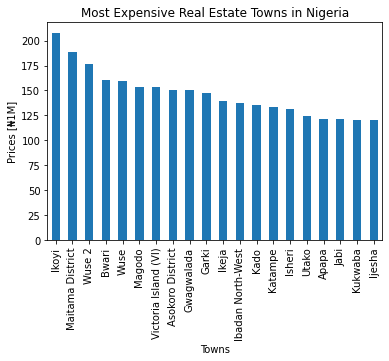

In [11]:
(
    (trimmed_df.groupby("town")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(20)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate Towns in Nigeria")
);

As communicated by the dataset, Lagos State has the most expensive houses on average. Abuja comes in as the second most expensive.


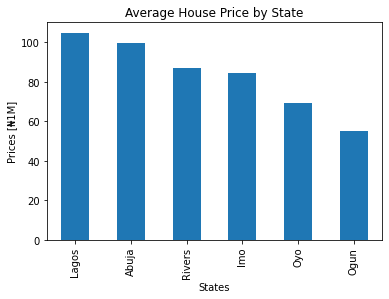

In [12]:
#States with the highest mean prices
(
    (trimmed_df.groupby("state")["price"].mean()/1e6)
    .sort_values(ascending=False)
    .plot(kind="bar",
         xlabel = "States", 
         ylabel = "Prices [₦1M]",
          title = "Average House Price by State"
        )
);

In [13]:
trimmed_df["state"].value_counts()

Lagos     13805
Abuja      2462
Rivers      339
Oyo         229
Imo         195
Ogun        141
Name: state, dtype: int64

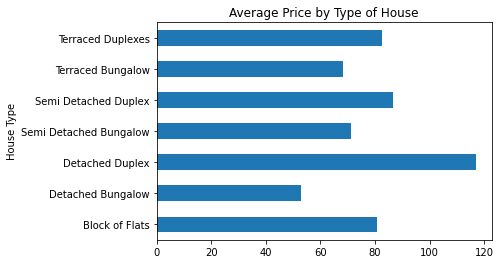

In [14]:
(
    (trimmed_df.groupby("title")["price"]
     .mean()/1e6)
    .plot(kind="barh",
          xlabel= 'House Type',
          ylabel = "Prices [₦1M]",
          title = "Average Price by Type of House"
         )
);

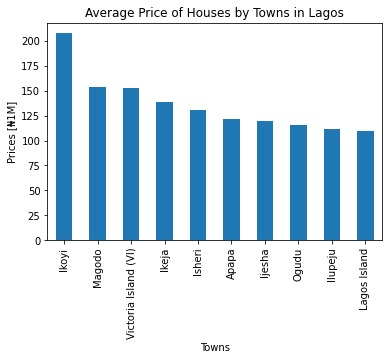

In [15]:
trimmed_df_lagos = trimmed_df[trimmed_df["state"]=="Lagos"]
(
    (trimmed_df_lagos.groupby("town")["price"].mean()/1e6)
    .sort_values(ascending=False)
    .head(10).plot(kind="bar",
                   xlabel = "Towns",
                   ylabel = "Prices [₦1M]",
                   title = "Average Price of Houses by Towns in Lagos"
                  )
);

In [16]:
trimmed_df_lagos["town"].value_counts()

Lekki                   9134
Ajah                    1797
Ikeja                    609
Magodo                   360
Victoria Island (VI)     300
Ikoyi                    255
Ibeju Lekki              193
Isheri North             183
Isolo                    164
Surulere                 106
Alimosho                  92
Yaba                      75
Maryland                  58
Agege                     56
Ojodu                     55
Gbagada                   51
Ikorodu                   49
Ogudu                     43
Amuwo Odofin              40
Ilupeju                   29
Ipaja                     22
Ikotun                    21
Shomolu                   15
Ojo                       15
Isheri                    15
Ketu                      13
Ifako-Ijaiye              13
Oshodi                     9
Ejigbo                     7
Idimu                      4
Kosofe                     3
Lagos Island               3
Agbara-Igbesa              3
Apapa                      3
Ijaiye        

In [17]:
df_lekki = trimmed_df_lagos[trimmed_df_lagos['town']=="Lekki"].reset_index()
df_lekki.drop(columns=["index", "state"], inplace=True)

In [18]:
df_lekki.describe()

,bedrooms,bathrooms,toilets,parking_space,price
count,9134.000000,9134.000000,9134.000000,9134.000000,9.134000e+03
mean,4.471097,4.697613,5.427414,3.986643,1.074863e+08
std,0.681831,0.763707,0.760587,1.121365,4.855801e+07
min,1.000000,1.000000,1.000000,1.000000,3.500000e+07
25%,4.000000,4.000000,5.000000,4.000000,7.000000e+07
50%,5.000000,5.000000,5.000000,4.000000,9.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,1.300000e+08
max,9.000000,9.000000,9.000000,9.000000,2.600000e+08


In [19]:
# Renaming the title column house_type
df_lekki.rename({"title": "house_type"}, axis = 1, inplace=True)
df_lekki.head()

,bedrooms,bathrooms,toilets,parking_space,house_type,town,price
0,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,120000000.0
1,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,75000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,65000000.0
3,1.0,1.0,1.0,1.0,Detached Duplex,Lekki,200000000.0
4,4.0,5.0,6.0,3.0,Semi Detached Duplex,Lekki,65000000.0


Detached Duplex           6259
Semi Detached Duplex      1376
Terraced Duplexes         1232
Block of Flats             169
Semi Detached Bungalow      41
Detached Bungalow           38
Terraced Bungalow           19
Name: house_type, dtype: int64


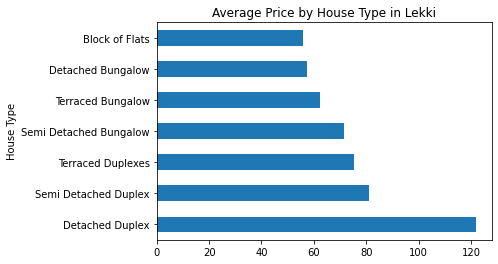

In [20]:
print(df_lekki["house_type"].value_counts())
(
    (df_lekki.groupby("house_type")["price"].mean()/1e6)
    .sort_values(ascending=False).
    plot(kind="barh",
         xlabel = "House Type",
         ylabel = "Prices [₦1M]",
         title = "Average Price by House Type in Lekki"
        )
);

In [21]:
df_lekki["total_rooms"] = df["bedrooms"] + df["bathrooms"] + df["toilets"] + df["parking_space"]
# Swap the positions of the price and total_rooms columns
cols = list(df_lekki.columns)
cols[-1], cols[-2] = cols[-2], cols[-1]
df_lekki = df_lekki[cols]

In [22]:
df_lekki

,bedrooms,bathrooms,toilets,parking_space,house_type,town,total_rooms,price
0,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,20.0,120000000.0
1,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,18.0,75000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,18.0,65000000.0
3,1.0,1.0,1.0,1.0,Detached Duplex,Lekki,19.0,200000000.0
4,4.0,5.0,6.0,3.0,Semi Detached Duplex,Lekki,15.0,65000000.0
...,...,...,...,...,...,...,...,...
9129,4.0,4.0,5.0,3.0,Terraced Duplexes,Lekki,26.0,75000000.0
9130,4.0,5.0,5.0,4.0,Semi Detached Duplex,Lekki,9.0,110000000.0
9131,3.0,4.0,4.0,5.0,Detached Duplex,Lekki,17.0,80000000.0
9132,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,21.0,68000000.0


The new feature created had a very poor correlation with the target variable.

-0.0020368542501899875

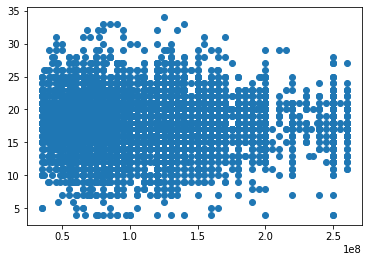

In [23]:
plt.scatter(
    x = df_lekki["price"],
    y = df_lekki["total_rooms"]
)
df_lekki["price"].corr(df_lekki["total_rooms"])

### **Checking for Multi-Collinearity**

               bedrooms  bathrooms   toilets  parking_space  total_rooms  \
bedrooms       1.000000   0.750079  0.768076       0.315122     0.010758   
bathrooms      0.750079   1.000000  0.762202       0.306990    -0.006481   
toilets        0.768076   0.762202  1.000000       0.299910     0.011514   
parking_space  0.315122   0.306990  0.299910       1.000000     0.007555   
total_rooms    0.010758  -0.006481  0.011514       0.007555     1.000000   
price          0.525320   0.405033  0.411606       0.274123    -0.002037   

                  price  
bedrooms       0.525320  
bathrooms      0.405033  
toilets        0.411606  
parking_space  0.274123  
total_rooms   -0.002037  
price          1.000000  


<AxesSubplot:>

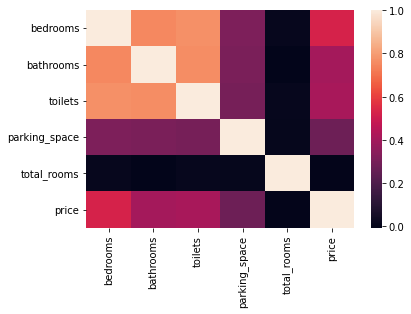

In [24]:
corr = df_lekki.corr()
print(corr)
sns.heatmap(corr)

In [25]:
# Drop multi-collinearity and low-cardinality features and feature not correlating with target
df_lekki.drop(columns=["bathrooms", "toilets", "town", "total_rooms"], inplace=True)

### **Removing Outliers**

In [26]:
trim = q1, q9 = df_lekki["price"].quantile([0.1,0.9])
mask = df_lekki["price"].between(q1,q9)
trimmed_df_lekki = df_lekki[mask]

In [27]:
trimmed_df_lekki["price"].sort_values().head()

7397    55000000.0
6960    55000000.0
644     55000000.0
6936    55000000.0
3619    55000000.0
Name: price, dtype: float64

In [28]:
print(trimmed_df_lekki.head())
print(len(trimmed_df_lekki))
trimmed_df_lekki.max()

   bedrooms  parking_space            house_type        price
0       4.0            4.0       Detached Duplex  120000000.0
1       4.0            2.0  Semi Detached Duplex   75000000.0
2       4.0            4.0       Detached Duplex   65000000.0
4       4.0            3.0  Semi Detached Duplex   65000000.0
5       4.0            4.0  Semi Detached Duplex   70000000.0
7526


bedrooms                       8.0
parking_space                  9.0
house_type       Terraced Duplexes
price                  170000000.0
dtype: object

# **Split Data**

In [29]:
target =  "price"
features = (trimmed_df_lekki.drop(columns = target)).columns
y = trimmed_df_lekki[target]
X = trimmed_df_lekki[features]
print(X)
print(y)

      bedrooms  parking_space            house_type
0          4.0            4.0       Detached Duplex
1          4.0            2.0  Semi Detached Duplex
2          4.0            4.0       Detached Duplex
4          4.0            3.0  Semi Detached Duplex
5          4.0            4.0  Semi Detached Duplex
...        ...            ...                   ...
9129       4.0            3.0     Terraced Duplexes
9130       4.0            4.0  Semi Detached Duplex
9131       3.0            5.0       Detached Duplex
9132       4.0            4.0       Detached Duplex
9133       4.0            4.0       Detached Duplex

[7526 rows x 3 columns]
0       120000000.0
1        75000000.0
2        65000000.0
4        65000000.0
5        70000000.0
           ...     
9129     75000000.0
9130    110000000.0
9131     80000000.0
9132     68000000.0
9133     65000000.0
Name: price, Length: 7526, dtype: float64


## **Train-Test-Split**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Train-Test-Split (Validation)

In [31]:
print(len(X_test))
print(round(len(X)*0.2))


1506
1505


# **Build Model**

### **Model Baseline**


In [32]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean price: 101915054.8179402
Baseline MAE: 28144187.62008587


## **Model**

In [33]:
model = make_pipeline(OneHotEncoder(use_cat_names=True),Ridge())
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['house_type'], use_cat_names=True)),
                ('ridge', Ridge())])

In [34]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_pred_training, y_train))

Training MAE: 21817560.71552872


<AxesSubplot:>

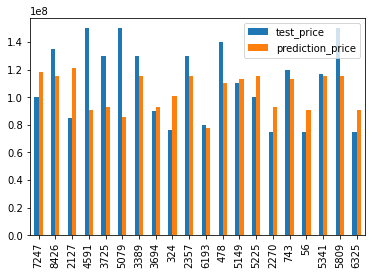

In [35]:
prediction_data = model.predict(X_test)
model_result = pd.DataFrame({'test_price': y_test, "prediction_price": prediction_data})
model_result.tail(20).plot(kind="bar")

In [36]:
print("Test MAE:", mean_absolute_error(prediction_data, y_test))

Test MAE: 21140344.333580773


In [37]:
trimmed_df_lekki.iloc[4902]

bedrooms                     5.0
parking_space                6.0
house_type       Detached Duplex
price                140000000.0
Name: 5935, dtype: object

# **Result Communication**

In [38]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("intercept:", intercept)
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

intercept: -9954261.556066543
coefficients len: 9
[ 22472085.53066787   2643343.40835888   2686222.10223658
 -12671873.2847402     559975.20924007]


In [39]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names)

features len: 9
['bedrooms', 'parking_space', 'house_type_Detached Duplex', 'house_type_Semi Detached Duplex', 'house_type_Terraced Duplexes', 'house_type_Detached Bungalow', 'house_type_Block of Flats', 'house_type_Terraced Bungalow', 'house_type_Semi Detached Bungalow']


In [40]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp

bedrooms                             2.247209e+07
parking_space                        2.643343e+06
house_type_Detached Duplex           2.686222e+06
house_type_Semi Detached Duplex     -1.267187e+07
house_type_Terraced Duplexes         5.599752e+05
house_type_Detached Bungalow        -1.792535e+06
house_type_Block of Flats            2.074404e+07
house_type_Terraced Bungalow         8.472496e+06
house_type_Semi Detached Bungalow   -1.799832e+07
dtype: float64

The barplot below shows that the number of bedrooms affect the price the most. Also notice that, if the house is a Semi Detached Bungalow, the price of the house depreciates by about 18 million naira.

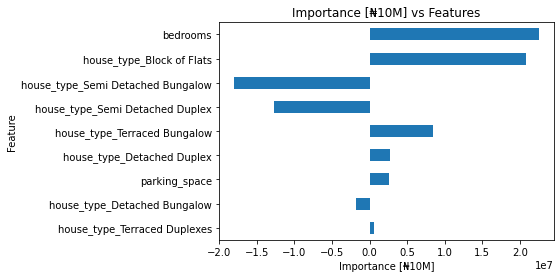

In [41]:
feat_imp.sort_values(key=abs).plot(kind="barh")
plt.xlabel("Importance [₦10M]")
plt.ylabel("Feature")
plt.title("Importance [₦10M] vs Features");

In [42]:
def make_prediction(bedrooms, parking_space, house_type):
    data = {"bedrooms":bedrooms,
            "parking_space":parking_space,
            "house_type":house_type
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ₦{prediction}"

### **Testing the Function**

In [43]:
make_prediction(4, 2, "Block of Flats")

'Predicted apartment price: ₦105964805.01'

In [44]:
interact(
    make_prediction,
    bedrooms=IntSlider(
        min=X_train["bedrooms"].min(),
        max=X_train["bedrooms"].max(),
        value=X_train["bedrooms"].mean(),
    ),
    parking_space=IntSlider(
        min=X_train["parking_space"].min(),
        max=X_train["parking_space"].max(),
        step=1,
        value=X_train["parking_space"].mean(),
    ),
    house_type=Dropdown(options=sorted(X_train["house_type"].unique())),
);

interactive(children=(IntSlider(value=4, description='bedrooms', max=8, min=1), IntSlider(value=3, description…

# **Conclusions**

* Excluding Banana Island in Lagos, Ikoyi has the most expensive houses in Nigeria, second to Maitama District in Abuja.
* The number of bedrooms in a house in Lekki is key in predicting the price of the house. Infact, one room should cost about 21 million naira on average. The number of rooms times 21 million naira will get you closer to the overall price of the house.
* Surprisingly, an apartment in a Block of Flats will cost about 17 million naira more than a Detached Duplex on average.
* If the house is a Semi-detached Bungalow, the price should depreciate by about 18 million naira. My hypothesis is that the style does not appeal to what the inhabitants of the town view as luxury.
* Some features are highly correlated. For example, the more the bedrooms, the more the bathrooms so the number of bathrooms is not needed for the model to predict the price of a house.
* The number of parking spaces in a house contributes to the overall price of the house with one parking space contributing about 3 million naira to the overall price of the house.


In [45]:
print("Hope you found this useful")

Hope you found this useful
